# Linear Mixed-Effect Regression

[Linear Mixed-Effect Regression](https://en.wikipedia.org/wiki/Mixed_model) (LMER) take on the following functional form,

$y = X \beta + Z u + \epsilon$, 

where

- $y$ is the dependent variable
- $X$ is the design matrix for fixed effects (variables that have a constant effect on $y$ regardless of groups),
- $Z$ is the design matrix for random effects (variables that have different effects on $y$ across groups),
- $\beta$ is a vector of the coefficients for the fixed effects corresponding to $X$,
- $u$ is a vector of the coefficients for the random effects corresponding to $Z$, and
- $\epsilon$ is the random error.

LMER models are typically used to model data that can be grouped. For example, if you have a dataset of elementary students, they can be grouped into classrooms. The data being able to be grouped implies that the units (eg students) are related. Since the units are related, normal regression, like ordinary least-squares (OLS), may be inappropriate when they assume that units are independently and identically distributed (IID). Let's take a look at LMER modeling.

## Load data

The data and code below is taken from this [post](https://www.pythonfordatascience.org/mixed-effects-regression-python/) and [were part of a study]((https://search.r-project.org/CRAN/refmans/WWGbook/html/ratpup.html)) in which 30 female rats were randomly assigned to receive one of three doses (High, Low, or Control) of an experimental compound and the weights of their pups were measured as the effect of the chemical compound. The lowest unit of analysis is at the pup level, and these pups are further grouped into litters. We have the following variables.

- $y$ = weight
- $X$ = {sex, litsize, treatment}
- $Z$ = litter

In [1]:
import pandas as pd

df = pd.read_csv('http://www-personal.umich.edu/~bwest/rat_pup.dat', sep='\t') \
    .set_index(['pup_id'])
df.shape

(322, 5)

In [2]:
df.dtypes

weight       float64
sex           object
litter         int64
litsize        int64
treatment     object
dtype: object

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 1 to 322
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   weight     322 non-null    float64
 1   sex        322 non-null    object 
 2   litter     322 non-null    int64  
 3   litsize    322 non-null    int64  
 4   treatment  322 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 15.1+ KB


In [4]:
df.isna().sum()

weight       0
sex          0
litter       0
litsize      0
treatment    0
dtype: int64

In [5]:
df.head()

,weight,sex,litter,litsize,treatment
pup_id,,,,,
1,6.60,Male,1,12,Control
2,7.40,Male,1,12,Control
3,7.15,Male,1,12,Control
4,7.24,Male,1,12,Control
5,7.10,Male,1,12,Control


## Visualize features

Now let's pick some visualization to summarize each variable.

- The median weight is 6.
- There are more males (53%) than females (47%).
- There is imbalance across the litters.
- About 41% of the rat pups came from mothers that were not treated, followed by 39% whose mothers were treated with a low dose and 20% whose mothers were treated with a high dose.

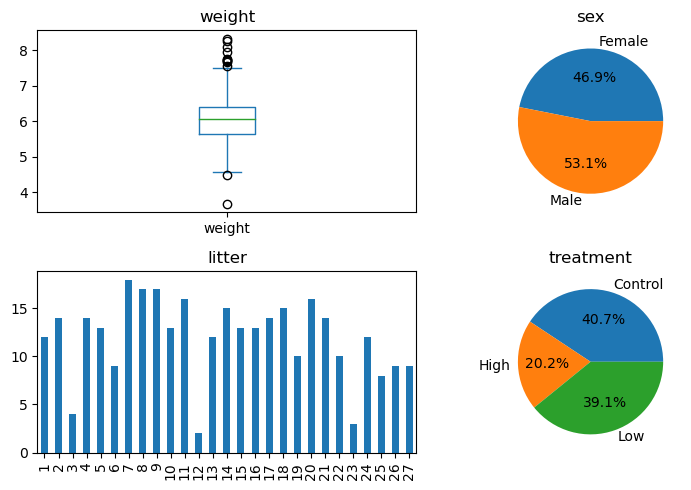

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax = np.ravel(ax)

df['weight'].plot(kind='box', ax=ax[0])
df['sex'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', ax=ax[1])
df['litter'].value_counts().sort_index().plot(kind='bar', ax=ax[2])
df['treatment'].value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', ax=ax[3])

ax[0].set_title('weight')
ax[1].set_title('sex')
ax[2].set_title('litter')
ax[3].set_title('treatment')
ax[1].set_ylabel('')
ax[3].set_ylabel('')

fig.tight_layout()

## Visualize weights by treatment and sex

We can see that the median weight for both males and females trend from high to low as we move from the control to low to high-treatment groups.

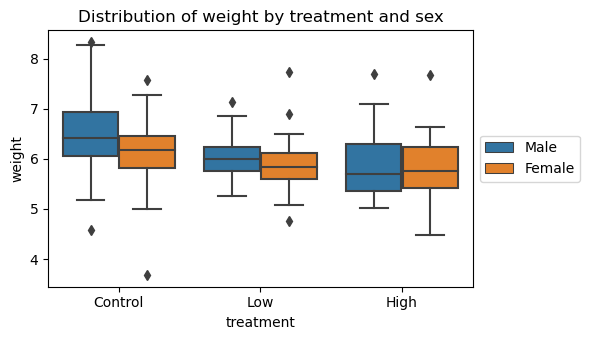

In [7]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 3.5))

sns.boxplot(data=df, x='treatment', y='weight', hue='sex', ax=ax)

ax.set_title('Distribution of weight by treatment and sex')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

## Linear model

Let's use a simple linear model for the data.

$y = X \beta + \epsilon$

In [8]:
import statsmodels.formula.api as smf

ols_model = smf.ols(
        formula='''weight ~ litsize + C(treatment) + C(sex, Treatment("Male"))''', 
        data=df) \
    .fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     54.76
Date:                Fri, 18 Aug 2023   Prob (F-statistic):           4.56e-35
Time:                        09:45:07   Log-Likelihood:                -231.84
No. Observations:                 322   AIC:                             473.7
Df Residuals:                     317   BIC:                             492.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               8.2240      0.156     52.864      0.000       7.918       8.530
C(treatment)[T.High]                   -0.9062      0.086    -10.554      0.000      -1.075      -0.737
C(treatment)[T.Low]                    -0.4250      0.063     -6.754      0.000      -0.549      -0.301
C(sex, Treatment("Male"))[T.Female]    -0.2739      0.056     -4.863      0.000      -0.385      -0.163
litsize                                -0.1249      0.010    -12.236      0.000      -0.145      -0.105
==============================================================================
Omnibus:                       61.833   Durbin-Watson:                   1.415
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.290
Skew:                          -0.693   Prob(JB):                     3.39e-64
Kurtosis:                       7.457   Cond. No.                         82.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## LMER, random intercept model

Now, we will use a LMER model allowing for the intercept to change. What do we mean by "allowing for the intercept to change?" We mean that there will be a different expected mean for each group (in the running example, each group is a litter of rat pups). Note the use of the `groups` parameter which is set to `litter`.

In [9]:
rim_model = smf.mixedlm(
        formula='''weight ~ litsize + C(treatment) + C(sex, Treatment('Male'))''',
        data=df, 
        groups='litter') \
    .fit()

rim_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                     MixedLM        Dependent Variable:        weight   
No. Observations:          322            Method:                    REML     
No. Groups:                27             Scale:                     0.1628   
Min. group size:           2              Log-Likelihood:            -198.4997
Max. group size:           18             Converged:                 Yes      
Mean group size:           11.9                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            8.310    0.274 30.355 0.000  7.773  8.846
C(treatment)[T.High]                -0.859    0.182 -4.722 0.000 -1.215 -0.502
C(treatment)[T.Low]                 -0.429    0.150 -2.849 0.004 -0.723 -0.134
C(sex, Treatment('Male'))[T.Female] -0.359    0.048 -7.540 0.000 -0.452 -0.266
litsize                             -0.129    0.019 -6.863 0.000 -0.166 -0.092
litter Var                           0.097    0.085                           
==============================================================================

"""

## LMER, random slope model, intercept and slopes independent

In this LMER model, we allow for the slope to change. In the LMER model where we allow for the intercept to change, the slopes are all the same and it is just the intercept that changes. Here, the slopes and intercepts changes per group, but the model does not assume interactions between the slopes and intercepts. Note the use of `vc_formula` parameter with the dictionary.

In [10]:
rsm_model = smf.mixedlm(
        formula='''weight ~ litsize + C(treatment) + C(sex, Treatment('Male'))''',
        data=df, 
        groups='litter',
        vc_formula = {'sex' : '0 + C(sex)'}) \
    .fit()

rsm_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                     MixedLM        Dependent Variable:        weight   
No. Observations:          322            Method:                    REML     
No. Groups:                27             Scale:                     0.1565   
Min. group size:           2              Log-Likelihood:            -205.7020
Max. group size:           18             Converged:                 Yes      
Mean group size:           11.9                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            8.231    0.234 35.185 0.000  7.772  8.689
C(treatment)[T.High]                -0.839    0.144 -5.827 0.000 -1.121 -0.557
C(treatment)[T.Low]                 -0.411    0.116 -3.526 0.000 -0.639 -0.182
C(sex, Treatment('Male'))[T.Female] -0.356    0.102 -3.508 0.000 -0.555 -0.157
litsize                             -0.124    0.016 -7.915 0.000 -0.155 -0.093
sex Var                              0.104    0.076                           
==============================================================================

"""

## LMER, random slope model, intercept and slopes dependent

In this LMER model, we allow for the slopes and intercepts to change and assume an interaction between the two. Note the use of `re_formula` and string literal formula.

In [11]:
ris_model = smf.mixedlm(
        formula='''weight ~ litsize + C(treatment) + C(sex, Treatment('Male'))''',
        data=df, 
        groups='litter',
        re_formula = '1 + C(sex)') \
    .fit()

ris_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                     MixedLM        Dependent Variable:        weight   
No. Observations:          322            Method:                    REML     
No. Groups:                27             Scale:                     0.1601   
Min. group size:           2              Log-Likelihood:            -196.3946
Max. group size:           18             Converged:                 Yes      
Mean group size:           11.9                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            8.166    0.265 30.765 0.000  7.645  8.686
C(treatment)[T.High]                -0.778    0.172 -4.523 0.000 -1.116 -0.441
C(treatment)[T.Low]                 -0.387    0.137 -2.821 0.005 -0.656 -0.118
C(sex, Treatment('Male'))[T.Female] -0.359    0.053 -6.783 0.000 -0.463 -0.255
litsize                             -0.120    0.018 -6.637 0.000 -0.155 -0.084
litter Var                           0.063    0.074                           
litter x C(sex)[T.Male] Cov          0.028    0.044                           
C(sex)[T.Male] Var                   0.013    0.062                           
==============================================================================

"""

Below is the estimated correlation coefficient between the random intercepts and random slopes. This correlation indicates that the litters with higher weight tend to have males that are of higher weight.

In [12]:
ris_model.params['litter x C(sex)[T.Male] Cov'] / np.sqrt(ris_model.params['litter Var'] * ris_model.params['C(sex)[T.Male] Var'])

0.9878805022022777

## Performance

Let's look at the non-validated performance measures. The MAE, RMSE, MAPE and $R^2$ are all comparable between these models, but the log-likelihood is better for the random intercept, random slope model.

- RIS: random intercept, random slope
- RIM: random intercept
- RSM: random slope
- OLS: ordinary least square

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def get_performance(m, X, y_true, Z=None, clusters=None):
    if Z is not None and clusters is not None:
        y_pred = m.predict(X, Z, clusters)
    else:
        y_pred  = m.predict(X)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rsq = r2_score(y_true, y_pred)
    
    try:
        ll = m.llf
    except:
        ll = np.nan
    
    y_pred = pd.Series([mae, rmse, mape, rsq, ll], index=['mae', 'rmse', 'mape', 'r-sq', 'log-likelihood'])
    return y_pred

lmer_df = pd.DataFrame([get_performance(m, df[['litsize', 'treatment', 'sex', 'litter']], df['weight']) 
              for m in [ols_model, rim_model, rsm_model, ris_model]], 
             index=['OLS', 'RIM', 'RSM', 'RIS']) \
    .sort_values(['log-likelihood'], ascending=False)
lmer_df

,mae,rmse,mape,r-sq,log-likelihood
RIS,0.383076,0.500760,0.064635,0.399894,-196.394596
RIM,0.382219,0.499605,0.064361,0.402659,-198.499691
RSM,0.381596,0.499295,0.064256,0.403400,-205.702007
OLS,0.376124,0.497108,0.063282,0.408616,-231.836723


## Mixed-Effects Random Forest

[Mixed-Effects Random Forest](https://www.tandfonline.com/doi/abs/10.1080/00949655.2012.741599) (MERF) is another approach to mixed-effect modeling. The [functional form of the model](https://imsarchives.nus.edu.sg/oldwww/Programs/014swclass/files/denis.pdf) is as follows,

- $y_i = f(X_i) + Z_i u_i + e_i$
- $u_i \sim \mathcal{N}(0, D)$
- $e_i \sim \mathcal{N}(0, \sigma_i)$

where,

- $y_i$ is the vector of responses for the i-th cluster,
- $X_i$ is the fixed effects covariates associated with $y_i$,
- $Z_i$ is the random effects covariates associated with the $y_i$, and
- $e_i \sim \mathcal{N}(0, \sigma_i)$ is the vector of error for the i-th cluster.

The learned parameters in MERF are

- $f()$: a random forest that models the (potentially nonlinear) mapping from the fixed effect covariates to the response (common across all clusters),
- $D$: the covariance of the normal distribution from which each $u_i$ is drawn, and
- $\sigma_i$: the variance of $e_i$.

The random effects, $Z_i u_i$, is still assumed to be linear.

To use MERF, install the following package.

```bash
pip install git+https://github.com/manifoldai/merf.git
```

Now let's shape the data for input into MERF.

In [14]:
sex_map = {'Male': 1, 'Female': 0}
treatment_map = {'Control': 0, 'Low': 1, 'High': 2}

X = df[['litsize', 'treatment', 'sex']] \
        .assign(
            sex=lambda d: d['sex'].map(sex_map),
            treatment=lambda d: d['treatment'].map(treatment_map)
        )
# Z = pd.DataFrame({'Z': np.ones(X.shape[0])}, index=X.index)
Z = df[['sex']].assign(sex=lambda d: d['sex'].map(sex_map))
clusters = df['litter']
y = df['weight']

X.shape, Z.shape, y.shape, clusters.shape

((322, 3), (322, 1), (322,), (322,))

By default, MERF uses a random forest to model the fixed effects. You will see that the way the parameters are learned is through an iteration procedure. In particular, the parameters are learned using the [Expectation-Maximization Algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm).

In [15]:
from merf import MERF
from sklearn.ensemble import RandomForestRegressor

merf = MERF(
    fixed_effects_model=RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=37),
    max_iterations=20
)
merf.fit(X, Z, clusters, y)

INFO     [merf.py:307] Training GLL is -333.71605873307544 at iteration 1.
INFO     [merf.py:307] Training GLL is -377.01192150920764 at iteration 2.
INFO     [merf.py:307] Training GLL is -385.0144049452151 at iteration 3.
INFO     [merf.py:307] Training GLL is -388.49413213816604 at iteration 4.
INFO     [merf.py:307] Training GLL is -390.786958923229 at iteration 5.
INFO     [merf.py:307] Training GLL is -392.6172680813943 at iteration 6.
INFO     [merf.py:307] Training GLL is -394.1013482379355 at iteration 7.
INFO     [merf.py:307] Training GLL is -395.3064926013952 at iteration 8.
INFO     [merf.py:307] Training GLL is -396.2790567471805 at iteration 9.
INFO     [merf.py:307] Training GLL is -397.0650753333675 at iteration 10.
INFO     [merf.py:307] Training GLL is -397.70311641522136 at iteration 11.
INFO     [merf.py:307] Training GLL is -398.2237484173181 at iteration 12.
INFO     [merf.py:307] Training GLL is -398.65074861675413 at iteration 13.
INFO     [merf.py:307] Trainin

You can see from the merged results of LMER and MERF that MERF performs better (non-validated).

In [16]:
merf_df = pd.DataFrame([get_performance(merf, X, y, Z, clusters)], index=['MERF'])

pd.concat([lmer_df, merf_df])

,mae,rmse,mape,r-sq,log-likelihood
RIS,0.383076,0.500760,0.064635,0.399894,-196.394596
RIM,0.382219,0.499605,0.064361,0.402659,-198.499691
RSM,0.381596,0.499295,0.064256,0.403400,-205.702007
OLS,0.376124,0.497108,0.063282,0.408616,-231.836723
MERF,0.278688,0.376164,0.046600,0.661372,NaN


MERF is flexible enough to allow any linear or non-linear regressor to model the fixed effects. We are using a linear model here to model the fixed effects. This linear model for the fixed effects using the MERF API should reduce back to LMER.

In [17]:
from sklearn.linear_model import LinearRegression

merf_linear = MERF(
    fixed_effects_model=LinearRegression(), 
    max_iterations=20
)
merf_linear.fit(X, Z, clusters, y)

INFO     [merf.py:307] Training GLL is -250.32226566191966 at iteration 1.
INFO     [merf.py:307] Training GLL is -275.4248038416475 at iteration 2.
INFO     [merf.py:307] Training GLL is -278.405863266045 at iteration 3.
INFO     [merf.py:307] Training GLL is -279.14089177633406 at iteration 4.
INFO     [merf.py:307] Training GLL is -279.39470078845005 at iteration 5.
INFO     [merf.py:307] Training GLL is -279.50761907216946 at iteration 6.
INFO     [merf.py:307] Training GLL is -279.56454572394097 at iteration 7.
INFO     [merf.py:307] Training GLL is -279.59504914913975 at iteration 8.
INFO     [merf.py:307] Training GLL is -279.6118859892217 at iteration 9.
INFO     [merf.py:307] Training GLL is -279.62124285234916 at iteration 10.
INFO     [merf.py:307] Training GLL is -279.6263549945002 at iteration 11.
INFO     [merf.py:307] Training GLL is -279.62900945894233 at iteration 12.
INFO     [merf.py:307] Training GLL is -279.6302331119333 at iteration 13.
INFO     [merf.py:307] Trai

In this MERF example, we use something fancier, gradient boosting, to model the fixed effects.

In [18]:
from lightgbm import LGBMRegressor

merf_lbgm = MERF(
    fixed_effects_model=LGBMRegressor(), 
    max_iterations=20
)
merf_lbgm.fit(X, Z, clusters, y)

INFO     [merf.py:307] Training GLL is -280.8403423506038 at iteration 1.
INFO     [merf.py:307] Training GLL is -312.5902759696268 at iteration 2.
INFO     [merf.py:307] Training GLL is -319.42122808679375 at iteration 3.
INFO     [merf.py:307] Training GLL is -323.30449745760814 at iteration 4.
INFO     [merf.py:307] Training GLL is -325.39602517001947 at iteration 5.
INFO     [merf.py:307] Training GLL is -325.97589056606364 at iteration 6.
INFO     [merf.py:307] Training GLL is -326.50014975589113 at iteration 7.
INFO     [merf.py:307] Training GLL is -326.6869382890954 at iteration 8.
INFO     [merf.py:307] Training GLL is -326.67740437411493 at iteration 9.
INFO     [merf.py:307] Training GLL is -326.7714395331036 at iteration 10.
INFO     [merf.py:307] Training GLL is -327.54464523883496 at iteration 11.
INFO     [merf.py:307] Training GLL is -327.09840142944836 at iteration 12.
INFO     [merf.py:307] Training GLL is -327.4145901178239 at iteration 13.
INFO     [merf.py:307] Tra

The table below compares the LMER and MERF models. In general, MERF models using a non-linear model for the fixed effects does better than LMER models across all (non-validated) performance measures. The problem with random forest and gradient boosting is they have a higher chance to overfit as they have higher variance, as opposed to the LMER models, which have higher bias (see [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)). 

In [19]:
linear_df = pd.DataFrame([get_performance(merf_linear, X, y, Z, clusters)], index=['MERF_LINEAR'])
lgbm_df = pd.DataFrame([get_performance(merf_lbgm, X, y, Z, clusters)], index=['MERF_LGBM'])

pd.concat([lmer_df, merf_df, linear_df, lgbm_df])

,mae,rmse,mape,r-sq,log-likelihood
RIS,0.383076,0.500760,0.064635,0.399894,-196.394596
RIM,0.382219,0.499605,0.064361,0.402659,-198.499691
RSM,0.381596,0.499295,0.064256,0.403400,-205.702007
OLS,0.376124,0.497108,0.063282,0.408616,-231.836723
MERF,0.278688,0.376164,0.046600,0.661372,NaN
MERF_LINEAR,0.303176,0.415935,0.051168,0.585982,NaN
MERF_LGBM,0.286231,0.405772,0.047979,0.605967,NaN


## Learned parameters

Since model interpretability is important, you should look at the learned parameters. These are the parameters for the LMER model with random slopes and intercepts (slopes and intercepts are dependent).

In [20]:
ris_model.params

Intercept                              8.165656
C(treatment)[T.High]                  -0.778370
C(treatment)[T.Low]                   -0.387161
C(sex, Treatment('Male'))[T.Female]   -0.359242
litsize                               -0.119568
litter Var                             0.395468
litter x C(sex)[T.Male] Cov            0.175758
C(sex)[T.Male] Var                     0.080040
dtype: float64

For the MERF model using random forest to model the fixed effects, these are the feature importances of the fixed effects. You simply reference the random forest model and the `feature_importances_` attribute. Litter size is apparently the most important feature for the fixed effects.

In [21]:
pd.Series(merf.fe_model.feature_importances_, X.columns)

litsize      0.558371
treatment    0.331581
sex          0.110048
dtype: float64

To look at the influence at the group level (litter), print out the `trained_b`. The nomenclature for MERF is to use $b$ for the random effect coefficients (as opposed to LMER, which uses $u$ for the random effect coefficients and $b$ for the fixed effect coefficients). Do not let this cognitive friction confuse you. 

In [22]:
merf.trained_b.sort_index()

,0
1,-0.013010
2,-0.003138
3,0.000726
4,0.002064
5,0.077942
6,-0.002509
7,-0.039926
8,0.211264
9,-0.186452
10,-0.147620


## Validation

Let's split the data 70% (training) and 30% (testing) stratified by the litter identifier.

In [60]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    df[['litsize', 'treatment', 'sex', 'litter']] \
        .assign(
            sex=lambda d: d['sex'].map(sex_map),
            treatment=lambda d: d['treatment'].map(treatment_map)), 
    df['weight'], 
    test_size=0.30, 
    random_state=37, 
    shuffle=True,
    stratify=df['litter']
)

Z_tr = X_tr[['sex']]
Z_te = X_te[['sex']]

C_tr = X_tr['litter']
C_te = X_te['litter']

X_tr = X_tr.drop(columns=['litter'])
X_te = X_te.drop(columns=['litter'])

In [61]:
X_tr.shape, Z_tr.shape, C_tr.shape, y_tr.shape

((225, 3), (225, 1), (225,), (225,))

In [62]:
X_te.shape, Z_te.shape, C_te.shape, y_te.shape

((97, 3), (97, 1), (97,), (97,))

Let's make sure the proportions of litters in the training and testing folds are preserved.

In [69]:
s1 = df['litter'].value_counts().sort_index()
s2 = C_tr.value_counts().sort_index()
s3 = C_te.value_counts().sort_index()

p1 = s1 / s1.sum()
p2 = s2 / s2.sum()
p3 = s3 / s3.sum()

pd.DataFrame([p1, p2, p3], index=['X', 'X_tr', 'X_te']).T

,X,X_tr,X_te
1,0.037267,0.035556,0.041237
2,0.043478,0.044444,0.041237
3,0.012422,0.013333,0.010309
4,0.043478,0.044444,0.041237
5,0.040373,0.040000,0.041237
6,0.027950,0.026667,0.030928
7,0.055901,0.057778,0.051546
8,0.052795,0.053333,0.051546
9,0.052795,0.053333,0.051546
10,0.040373,0.040000,0.041237


Now let's validate.

In [72]:
def get_model():
    model = MERF(
        fixed_effects_model=RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=37),
        max_iterations=20
    )
    return model

def learn(X_tr, Z_tr, C_tr, y_tr):
    model = get_model()
    model.fit(X_tr, Z_tr, C_tr, y_tr)
    
    return model

def get_results(X_tr, Z_tr, C_tr, y_tr, X_te, Z_te, C_te, y_te):
    model = learn(X_tr, Z_tr, C_tr, y_tr)
    
    perf_tr = get_performance(model, X_tr, y_tr, Z_tr, C_tr)
    perf_te = get_performance(model, X_te, y_te, Z_te, C_te)
    
    return pd.DataFrame([perf_tr, perf_te], index=['tr', 'te']).drop(columns=['log-likelihood']).T

get_results(X_tr, Z_tr, C_tr, y_tr, X_te, Z_te, C_te, y_te)

INFO     [merf.py:307] Training GLL is -241.69649293327376 at iteration 1.
INFO     [merf.py:307] Training GLL is -286.11740133632026 at iteration 2.
INFO     [merf.py:307] Training GLL is -295.49781890130924 at iteration 3.
INFO     [merf.py:307] Training GLL is -300.5394268800354 at iteration 4.
INFO     [merf.py:307] Training GLL is -303.881513426677 at iteration 5.
INFO     [merf.py:307] Training GLL is -306.11984582945183 at iteration 6.
INFO     [merf.py:307] Training GLL is -307.9731073008684 at iteration 7.
INFO     [merf.py:307] Training GLL is -309.2839553256728 at iteration 8.
INFO     [merf.py:307] Training GLL is -310.34791724450554 at iteration 9.
INFO     [merf.py:307] Training GLL is -311.1151258488934 at iteration 10.
INFO     [merf.py:307] Training GLL is -311.7811932910758 at iteration 11.
INFO     [merf.py:307] Training GLL is -312.2844557199853 at iteration 12.
INFO     [merf.py:307] Training GLL is -312.67471304477255 at iteration 13.
INFO     [merf.py:307] Traini

,tr,te
mae,0.265837,0.328698
rmse,0.366546,0.426194
mape,0.044403,0.054894
r-sq,0.681957,0.553932


The validated MERF performance is still pretty good.